In [1]:
"""Imports & Project Setup"""

import sys
import os
import matplotlib.pyplot as plt
from pyspark.sql.functions import (
    col, sin, cos, dayofweek, when, avg, hour
)
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, PCA
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator

# Add parent directory to system path to import utils
sys.path.append(os.path.abspath('..'))
from utils import get_spark_session, PATHS

# Initialize Spark
spark = get_spark_session("LargeST-ML")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/09 16:56:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
"""Load Pre-processed Data"""

# Load the clean, enriched data generated in the Data Visualization step
# This avoids repeating the join/clean logic
print(f"Loading data from: {PATHS['clean_enriched']}")
clean_df = spark.read.parquet(PATHS['clean_enriched'])

Loading data from: hdfs:///user/ubuntu/largest_parquet_clean_enriched/clean_enriched


In [3]:
"""Feature Engineering: Cyclic Time & Rush Hour"""

# Add time-based features (Cyclic Hour, Weekend, Rush Hour)
clean_df = clean_df.withColumn("hour", hour(col("timestamp")))

clean_df = clean_df.withColumn(
    "hour_sin", sin(2 * 3.141592653589793 * col("hour") / 24)
).withColumn(
    "hour_cos", cos(2 * 3.141592653589793 * col("hour") / 24)
)

clean_df = clean_df.withColumn(
    "is_weekend",
    dayofweek(col("timestamp")).isin([1, 7]).cast("int")
)

clean_df = clean_df.withColumn(
    "is_rush",
    when(col("hour").isin([7, 8, 9, 16, 17, 18]), 1).otherwise(0)
)

In [4]:
"""Data Aggregation for ML"""

# Aggregate data to reduce dimensionality for simple ML demonstration
ml_df = (
    clean_df
    .groupBy(
        "sensor_id",
        "hour",
        "hour_sin",
        "hour_cos",
        "is_weekend",
        "is_rush",
        "Lanes",
        "Direction",
        "County"
    )
    .agg(
        avg("value").alias("mean_traffic")
    )
    .dropna()
    .cache()
)

print(f"Total samples for ML: {ml_df.count()}")

[Stage 3:====================================================>     (9 + 1) / 10]

Total samples for ML: 412800


In [5]:
"""Feature Pipeline: Indexing & Encoding"""

# Prepare categorical variables
direction_indexer = StringIndexer(
    inputCol="Direction",
    outputCol="Direction_idx",
    handleInvalid="keep"
)

county_indexer = StringIndexer(
    inputCol="County",
    outputCol="County_idx",
    handleInvalid="keep"
)

encoder = OneHotEncoder(
    inputCols=["Direction_idx", "County_idx"],
    outputCols=["Direction_ohe", "County_ohe"]
)

In [6]:
"""Feature Pipeline: Vector Assembly"""

feature_columns = [
    "hour_sin",
    "hour_cos",
    "is_weekend",
    "is_rush",
    "Lanes",
    "Direction_ohe",
    "County_ohe"
]

assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol="features"
)

In [7]:
"""Apply Pipeline & Cache Data"""

feature_pipeline = Pipeline(stages=[
    direction_indexer,
    county_indexer,
    encoder,
    assembler
])

ml_ready_df = feature_pipeline.fit(ml_df).transform(ml_df).cache()
ml_ready_df.select("features", "mean_traffic").show(5, truncate=False)

[Stage 20:=======================================>                 (7 + 3) / 10]

+----------------------------------------------------------------------+------------------+
|features                                                              |mean_traffic      |
+----------------------------------------------------------------------+------------------+
|(43,[1,4,6,12],[1.0,2.0,1.0,1.0])                                     |39.64865900383142 |
|(43,[0,1,4,7,18],[0.25881904510252074,0.9659258262890683,2.0,1.0,1.0])|5.354556485088447 |
|(43,[0,1,4,6,18],[0.49999999999999994,0.8660254037844387,4.0,1.0,1.0])|11.635689158938279|
|(43,[0,1,4,5,18],[0.7071067811865475,0.7071067811865476,3.0,1.0,1.0]) |62.39312240047534 |
|(43,[0,1,4,6,18],[0.7071067811865475,0.7071067811865476,5.0,1.0,1.0]) |332.5001915708812 |
+----------------------------------------------------------------------+------------------+
only showing top 5 rows



In [8]:
"""Train/Test Split"""

train_df, test_df = ml_ready_df.randomSplit([0.8, 0.2], seed=42)
print(f"Training set: {train_df.count()}, Test set: {test_df.count()}")

Training set: 330552, Test set: 82248


In [9]:
"""Linear Regression: Model Training"""

lr = LinearRegression(
    featuresCol="features",
    labelCol="mean_traffic"
)

lr_model = lr.fit(train_df)
print("Linear Regression model trained.")

26/01/09 17:10:12 WARN Instrumentation: [db3446b8] regParam is zero, which might cause numerical instability and overfitting.
26/01/09 17:10:14 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
26/01/09 17:10:14 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
[Stage 37:==================================>                      (6 + 4) / 10]

Linear Regression model trained.


In [10]:
"""Linear Regression: Evaluation (RMSE)"""

predictions = lr_model.transform(test_df)

rmse = RegressionEvaluator(
    labelCol="mean_traffic",
    predictionCol="prediction",
    metricName="rmse"
).evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Root Mean Squared Error (RMSE): 87.3753


In [11]:
"""Linear Regression: Feature Importance Extraction"""

# Extract coefficients for base features (excluding OHE vectors for simplicity in plot)
base_feature_names = [
    "hour_sin", "hour_cos", "is_weekend", "is_rush", "Lanes"
]

coefficients = lr_model.coefficients.toArray()[:len(base_feature_names)]

feature_importance_df = spark.createDataFrame(
    zip(base_feature_names, map(float, coefficients)),
    ["feature", "coefficient"]
).orderBy("coefficient", ascending=False)

feature_importance_df.show()

[Stage 42:>                                                         (0 + 6) / 6]

+----------+-------------------+
|   feature|        coefficient|
+----------+-------------------+
|     Lanes|  68.26990412534627|
|   is_rush|  31.38611086560584|
|is_weekend|-24.999604988979407|
|  hour_sin|-58.457720439726806|
|  hour_cos| -119.8232257281868|
+----------+-------------------+



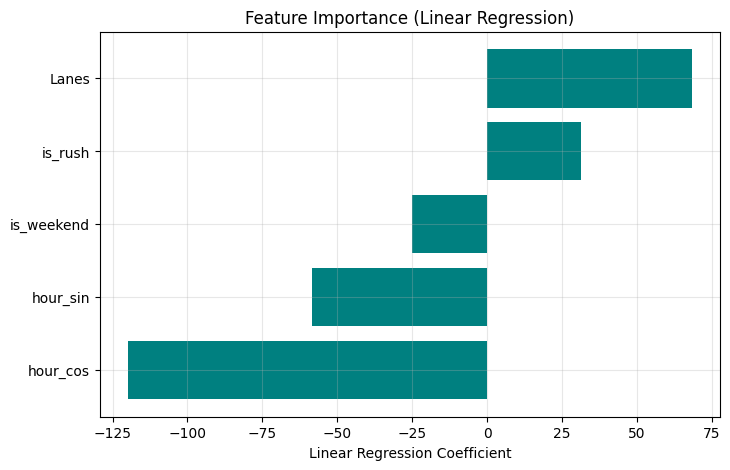

In [12]:
"""Linear Regression: Feature Importance Visualization"""

fi_pd = feature_importance_df.toPandas()

plt.figure(figsize=(8, 5))
plt.barh(fi_pd["feature"], fi_pd["coefficient"], color='teal')
plt.xlabel("Linear Regression Coefficient")
plt.title("Feature Importance (Linear Regression)")
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
"""Logistic Regression: Data Preparation"""

# Convert regression problem to binary classification (Rush Hour Detection)
# We treat 'is_rush' as the label to see if we can predict it from other features
classification_df = ml_ready_df.withColumnRenamed("is_rush", "label")

In [14]:
"""Logistic Regression: Model Training"""

log_reg = LogisticRegression(
    featuresCol="features",
    labelCol="label"
)

log_model = log_reg.fit(classification_df)
print("Logistic Regression model trained.")

Logistic Regression model trained.


In [15]:
"""Logistic Regression: Evaluation (AUC)"""

auc = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
).evaluate(
    log_model.transform(classification_df)
)

print(f"Area Under ROC (AUC): {auc:.4f}")

Area Under ROC (AUC): 1.0000


In [16]:
"""Dimensionality Reduction: PCA Training"""

pca = PCA(
    k=3,
    inputCol="features",
    outputCol="pca_features"
)

pca_model = pca.fit(ml_ready_df)
print(f"Explained Variance: {pca_model.explainedVariance.toArray()}")

[Stage 157:=================================>                      (6 + 3) / 10]

Explained Variance: [0.2742613  0.12427251 0.11816626]


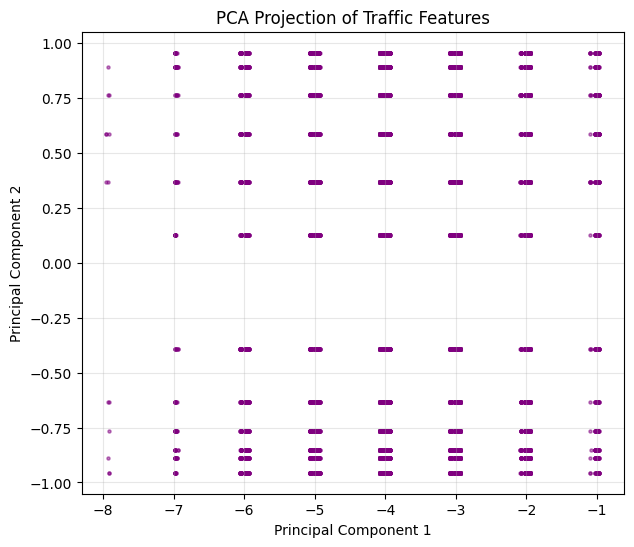

In [18]:
"""PCA: 2D Projection Visualization"""

pca_pd = (
    pca_model
    .transform(ml_ready_df)
    .select("pca_features")
    .sample(fraction=0.1, seed=42)
    .rdd
    .map(lambda r: r[0].toArray().tolist())
    .toDF(["PC1", "PC2", "PC3"])
    .toPandas()
)

plt.figure(figsize=(7, 6))
plt.scatter(pca_pd["PC1"], pca_pd["PC2"], s=5, alpha=0.5, c='purple')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of Traffic Features")
plt.grid(True, alpha=0.3)
plt.show()

In [19]:
"""Cleaning"""

spark.stop()